# Set up connection to WRDS

In [ ]:
# pip install wrds #[Nov 30, Shravan] run once and comment out


In [2]:
# from google.colab import drive #[Dec 2, Shravan] run once and comment out
# drive.mount('/content/drive')
# shared_drive_path = '/content/drive/MyDrive/AFP/Code/'

In [3]:
import wrds
import pandas as pd
from datetime import datetime, timedelta,date
import os,psycopg2


conn = wrds.Connection()

# https://wrds-www.wharton.upenn.edu/data-dictionary/crsp_a_stock/dsf/
# https://wrds-www.wharton.upenn.edu/pages/about/data-vendors/sp-global-market-intelligence/
# https://wrds-www.wharton.upenn.edu/data-dictionary/crsp_a_stock/dsfhdr/

# # Database Schema

# # Query to get column names for optionm.opprcd2023
# query_opprcd = """
# SELECT column_name
# FROM information_schema.columns
# WHERE table_schema = 'optionm' AND table_name = 'opprcd2023';
# """

# # Query to get column names for optionm.secnmd
# query_secnmd = """
# SELECT column_name
# FROM information_schema.columns
# WHERE table_schema = 'optionm' AND table_name = 'secnmd';
# """

# # Execute queries
# columns_opprcd = conn.raw_sql(query_opprcd)
# columns_secnmd = conn.raw_sql(query_secnmd)

# print("Columns in optionm.opprcd2023:")
# print(columns_opprcd)
# print("\nColumns in optionm.secnmd:")
# print(columns_secnmd)

# # Get SIC codes

# table = 'opprcd'+ year

# # Define the SQL query to retrieve biotech stock data
# query = f"""
#     SELECT DISTINCT s.ticker, s.secid
#     FROM optionm.{table} o
#     JOIN optionm.secnmd s ON o.secid = s.secid
#     WHERE s.sic BETWEEN '2833' AND '2836'  -- SIC codes for biotech industry
#       AND o.date BETWEEN '{start_date}' AND '{end_date}'
#     ORDER BY s.ticker;
# """

# data = conn.raw_sql(query)

# # Display the first few rows of the fetched data
# data

# # Print the total number of biotech stocks
# #print(f"Total number of biotech stocks: {len(data)}")

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


# Set up inputs for tickers and dates

In [4]:
path_tickers = r'Complete-List-of-Biotech-Stocks-Listed-on-NASDAQ-Jan-1-24.xlsx'  #[Dec 2, Shravan] joining file name with directory as well
tickers_df = pd.read_excel(path_tickers)
# tickers_df = pd.read_excel(r"Complete-List-of-Biotech-Stocks-Listed-on-NASDAQ-Jan-1-24.xlsx")
tickers = tickers_df['Ticker'].unique().tolist()

# Define the dates
start_year = 2022
start_month = 11
start_day = 10

end_year = 2022
end_month = 12
end_day = 12

# Create start_date and end_date using datetime
start_date = datetime(start_year, start_month, start_day)
end_date = datetime(end_year, end_month, end_day)

# Generate list of years between the start and end date (inclusive)
years = list(range(start_date.year, end_date.year + 1))

# Print the start and end dates
print("Start Date:", start_date.strftime("%Y-%m-%d"))
print("End Date:", end_date.strftime("%Y-%m-%d"))


Start Date: 2022-11-10
End Date: 2022-12-12


# Pull Equities Data


In [34]:
# # Function to get CUSIPs for tickers
def get_cusips(tickers):
    # Create a string of tickers in the form of ('ticker1', 'ticker2', ...)
    tickers_str = "('" + "','".join(tickers) + "')"

    query = f"""
        SELECT
             c.htsymbol, c.hcusip
        FROM
            crsp_a_stock.dsfhdr AS c
        WHERE
            c.htsymbol IN {tickers_str}
    """

    # Execute the query to get header data and return CUSIPs
    header = conn.raw_sql(query)

    # Remove rows with missing CUSIPs
    cusips = header.dropna()['hcusip'].unique().tolist()  # Ensure unique and drop NaN values
    return cusips


# # Function to query daily stock data for a list of CUSIPs ; removed the final market cap filter
# def query_daily_data(start_day: str, end_day: str, cusips: list):
#     # Create a string for the CUSIPs list in the form of ('cusip1', 'cusip2', ...)
#     cusips_str = "('" + "','".join(cusips) + "')"

#     query = f"""
#         SELECT
#             c.cusip,
#             b.ticker,  -- Use b.ticker instead of c.ticker
#             c.date,
#             c.bid,
#             c.ask,
#             c.vol,
#             c.shrout, -- shares outstanding
#             c.prc, -- price
#             (c.prc * c.shrout) AS mktcap -- calculate market cap (price * shares outstanding)
#         FROM
#             crsp_a_stock.dsf AS c
#         JOIN
#             crsp_a_stock.dsenames AS b
#         ON
#             c.permno = b.permno
#         WHERE
#             c.date BETWEEN '{start_day}' AND '{end_day}'
#             AND c.cusip IN {cusips_str}
#             -- AND (c.prc * c.shrout) BETWEEN 100000 AND 5000000000  -- Filter using calculated market cap (Commented out this filter)
#     """

#     # Execute the query to get daily data for the provided CUSIPs
#     data = conn.raw_sql(query)

#     return data

# # Get CUSIPs for the tickers
# cusips = get_cusips(tickers[0:2])

# # Query daily stock data for a specified date range and the obtained CUSIPs
# equities_data = query_daily_data(start_date, end_date, cusips)

# equities_data

## Understanding equities ticker to permno mapping

In [6]:
# tickers_str = "('" + "','".join(tickers) + "')"
# query = f"""
#         SELECT *
#         FROM
#             crsp_a_stock.dsfhdr AS c
#         WHERE
#             c.htsymbol IN {tickers_str}
#     """

# df = conn.raw_sql(query)

In [7]:
# print("Unique tickers:", df['htsymbol'].nunique())
# print("Unique PERMNOs:", df['permno'].nunique())
# print("Unique PERMCOs:", df['permco'].nunique())

In [8]:
# grouped = df.groupby('htsymbol').agg({
#     'permno': lambda x: ', '.join(map(str, x.unique())),
#     'permco': 'first',  # Assuming permco is consistent across PERMNOs
#     'hshrcd': lambda x: list(set(x)),  # Inspect unique share codes
#     'begdat': 'min',
#     'enddat': 'max'
# }).reset_index()

# print(grouped)

In [9]:
# # prompt: show the data frame in excel
# df.to_excel('df.xlsx')
# grouped.to_excel('grouped.xlsx')

In [10]:
# common_stocks = df[df['hshrcd'].isin([10, 11])]  # Filter for common stock codes
# common_stocks

In [11]:
# grouped_permco = df.groupby('permco').agg({
#     'permno': lambda x: ', '.join(map(str, x.unique())),
#     'htsymbol': lambda x: ', '.join(x.unique()),
#     'hcomnam': 'first'
# }).reset_index()
# print(grouped_permco)

In [12]:
# cleaned_df = df.groupby('htsymbol').agg({
#     'permno': lambda x: ', '.join(map(str, x.unique())),
#     'hcomnam': 'first',
#     'begdat': 'min',
#     'enddat': 'max'
# }).reset_index()

# print(cleaned_df)

In [13]:
# # Convert the 'date' column to datetime (if it's not already)
# df['date'] = pd.to_datetime(df['date'])

# # Sort by ticker and date
# df = df.sort_values(by=['htsymbol', 'date'])

# # Create the mapping of ticker to date-indexed PERMNO
# ticker_permno_mapping = df.groupby('htsymbol').apply(
#     lambda group: group.set_index('date')['permno']
# ).to_dict()

# # Print the resulting mapping
# for ticker, permno_series in ticker_permno_mapping.items():
#     print(f"Ticker: {ticker}")
#     print(permno_series)
#     print()

In [14]:
# import pandas as pd

# equities_data.to_excel('equities_data.xlsx', index=False)


In [15]:
stocks = tickers_df['Ticker']

In [16]:
def get_permnos(tickers):
    stock_str = "('" + "','".join(stocks)+ "')"
    query = f"""
        SELECT
             *
        FROM
            crsp_a_stock.dsfhdr AS c
        WHERE
            c.htsymbol IN {stock_str}
    """

    header = conn.raw_sql(query)
    return header.dropna()['permno']
permnos = get_permnos(stocks)

In [17]:
def query_daily_data(start_day: str, end_day: str, permnos: list):
    permnos_str = "(" + ",".join([str(i) for i in permnos])+ ")"

    query = f"""
    SELECT * FROM (
            SELECT
                c.permno,
                c.cusip,
                c.date,
                c.bid,
                c.ask,
                c.vol,
                c.shrout, -- shares outstanding
                c.prc, -- price
               (c.prc * c.shrout) AS mktcap -- calculated market cap
            FROM
                crsp_a_stock.dsf AS c
            WHERE
                c.date BETWEEN '{start_day}' AND '{end_day}'
                AND c.permno IN {permnos_str}
            ) as subquery
        WHERE
            subquery.mktcap BETWEEN 100000 AND 5000000000
    """

    data = conn.raw_sql(query)

    return data

In [18]:
data = query_daily_data(start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"), permnos)

In [19]:
equities_data = data

# Pull Options Data

In [20]:
# !pip install ipdb
# %pdb off
# import ipdb

In [21]:
def get_tickers_to_permno_mapping(tickers):
    # Convert 'begdat' and 'enddat' to datetime
    tickers_str = "('" + "','".join(tickers) + "')"
    query = f"""
            SELECT *
            FROM
                crsp_a_stock.dsfhdr AS c
            WHERE
                c.htsymbol IN {tickers_str}
        """

    df = conn.raw_sql(query)
    df['begdat'] = pd.to_datetime(df['begdat'])
    df['enddat'] = pd.to_datetime(df['enddat'])

    # Initialize the mapping dictionary
    ticker_permno_mapping = {}

    # Iterate over the rows to create the desired dictionary
    for _, row in df.iterrows():
        ticker = row['htsymbol']
        permno = row['permno']
        date_tuple = (row['begdat'], row['enddat'])

        # Check if the ticker is already in the mapping
        if ticker not in ticker_permno_mapping:
            ticker_permno_mapping[ticker] = {}

        # Add the date tuple and corresponding permno to the ticker's dictionary
        ticker_permno_mapping[ticker][date_tuple] = permno

    return ticker_permno_mapping

In [22]:
def fetch_options_data(tickers, start_date, end_date, years):
    """
    Fetch options data for given tickers across multiple years with improved error handling
    and data validation.
    """
    all_options_data = []  # List to store concatenated results
    valid_data_found = False  # Flag to track if any valid data was found

    # Input validation
    if not tickers or not isinstance(tickers, list): #checking for not null or list instance
        raise ValueError("Tickers must be provided as a non-empty list")
    if not years or not isinstance(years, list): #checking for not null or list instance
        raise ValueError("Years must be provided as a non-empty list")

    # Loop over each year in the list
    for year in years:
        year_data = None
        try:
            table = 'opprcd' + str(year)
            # Create the SQL query with multiple tickers using IN clause
            tickers_str = "','".join(tickers)
            query = f"""
                SELECT o.date, s.ticker, o.exdate, o.cp_flag, o.strike_price,
                       o.strike_price / 10000 AS strike_price_actual,
                       o.best_bid, o.best_offer, o.volume, o.open_interest,
                       o.impl_volatility, o.delta, o.gamma, o.vega, o.theta
                FROM optionm.{table} o
                JOIN (
                    SELECT DISTINCT secid, ticker
                    FROM optionm.secnmd
                ) AS s ON o.secid = s.secid
                WHERE s.ticker IN ('{tickers_str}')
                  AND o.date BETWEEN '{start_date}' AND '{end_date}'
                ORDER BY o.date, s.ticker, o.exdate, o.strike_price;
            """

            # Execute the query
            year_data = conn.raw_sql(query)
            # ipdb.set_trace(context=5)

            # Validate returned data
            if year_data is not None and isinstance(year_data, (list, pd.DataFrame)):
                if len(year_data) > 0:
                    # Check if data has the expected structure
                    expected_columns = ['date', 'ticker', 'exdate', 'cp_flag', 'strike_price',
                                     'best_bid', 'best_offer', 'volume', 'open_interest',
                                     'impl_volatility', 'delta', 'gamma', 'vega', 'theta']

                    if isinstance(year_data, pd.DataFrame):
                        if all(col in year_data.columns for col in expected_columns):
                            all_options_data.append(year_data)
                            valid_data_found = True
                            print(f"\nOptions data for year {year}:")
                            print(f"Total number of options contracts: {len(year_data)}")
                            print("\nSample of options data:")
                            print(year_data.head())  # Display first 5 records
                        else:
                            print(f"Warning: Data for year {year} has unexpected structure")
                    else:  # If it's a list
                        all_options_data.extend(year_data)
                        valid_data_found = True
                        print(f"\nOptions data for year {year}:")
                        print(f"Total number of options contracts: {len(year_data)}")
                        print("\nSample of options data:")
                        print(year_data[:5])  # Display first 5 records
                else:
                    print(f"No data found for year {year}")
            else:
                print(f"Invalid or empty data returned for year {year}")

        except pd.errors.EmptyDataError:
            print(f"No data available for year {year}")
        except (ValueError, AttributeError) as e:
            print(f"Data validation error for year {year}: {e}")
        except Exception as e:
            if "UndefinedTable" in str(e):
                print(f"Table for year {year} does not exist in the database")
            else:
                print(f"Error processing data for year {year}: {e}")

    # Final validation of concatenated data
    if not valid_data_found:
        print("\nWarning: No valid data was found for any year")
        return pd.DataFrame()  # Return empty DataFrame instead of None

    # Combine all data
    if all_options_data:
        if isinstance(all_options_data[0], pd.DataFrame):
            final_data = pd.concat(all_options_data, ignore_index=True)
        else:
            final_data = pd.DataFrame(all_options_data)

        # Display the overall summary
        print("\nOverall options data summary:")
        print(f"Total number of options contracts fetched: {len(final_data)}")
        return final_data
    else:
        return pd.DataFrame()  # Return empty DataFrame if no data

# Usage example:
try:
    options_data = fetch_options_data(tickers, start_date, end_date, years)
    if not options_data.empty:
        print("\nData fetched successfully")
    else:
        print("\nNo valid data was returned")
except Exception as e:
    print(f"Error in main execution: {e}")


Options data for year 2022:
Total number of options contracts: 1393693

Sample of options data:
         date ticker      exdate cp_flag  strike_price  strike_price_actual  \
0  2022-11-10   AADI  2022-11-18       C        2500.0                 0.25   
1  2022-11-10   AADI  2022-11-18       P        2500.0                 0.25   
2  2022-11-10   AADI  2022-11-18       P        5000.0                 0.50   
3  2022-11-10   AADI  2022-11-18       C        5000.0                 0.50   
4  2022-11-10   AADI  2022-11-18       C        7500.0                 0.75   

   best_bid  best_offer  volume  open_interest  impl_volatility     delta  \
0      10.3        12.5     0.0            0.0         7.916858  0.979245   
1       0.0         4.7     0.0            0.0              NaN       NaN   
2       0.0         4.7     0.0            0.0              NaN       NaN   
3       8.1        10.0     0.0            0.0         5.578606  0.948884   
4       3.9         7.5     0.0            

In [23]:
print(options_data.shape)
import numpy as np
volume_threshold_options_data = options_data[options_data['volume'] > np.percentile(options_data['volume'], 80)]
print(volume_threshold_options_data.shape)
ticker_to_permno_mapping = get_tickers_to_permno_mapping(tickers)

def get_permno(row, ticker_to_permno_mapping, asofdate):
    '''function to get permno corresponding to ticker asofdate'''
    ticker = row['ticker']
    for date_tuple, permno in ticker_to_permno_mapping.get(ticker, {}).items():
        if date_tuple[0] <= asofdate <= date_tuple[1]:
            return permno
    return None  # If today's date is not in any of the date ranges

# Apply the function to create the 'permno' column
volume_threshold_options_data['permno'] = volume_threshold_options_data.apply(get_permno, axis=1, args=(ticker_to_permno_mapping, pd.Timestamp('2023-12-01'),))

print(volume_threshold_options_data.shape)
print(volume_threshold_options_data['permno'].isna().any())

(1393693, 15)
(159175, 15)
(159175, 16)
False


/var/folders/1w/11tc25ps6ts6s9qzm42mm3j40000gn/T/ipykernel_16693/3351709838.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume_threshold_options_data['permno'] = volume_threshold_options_data.apply(get_permno, axis=1, args=(ticker_to_permno_mapping, pd.Timestamp('2023-12-01'),))


In [24]:
# table = 'opprcd' + str(2022)
# # Create the SQL query with multiple tickers using IN clause
# # query = f"""
# #     SELECT *
# #     FROM optionm.{table} o
# #     WHERE o.secid IN ('211519')
# #     ORDER BY o.secid;
# # """
# query = f"""
#     SELECT *
#     FROM optionm.{table} o
#     JOIN (
#         SELECT DISTINCT secid, ticker
#         FROM optionm.secnmd
#     ) AS s ON o.secid = s.secid
#     WHERE o.secid IN ('211519')
#     ORDER BY o.date, s.ticker, o.exdate, o.strike_price;
# """

# # Execute the query
# year_data = conn.raw_sql(query)

In [25]:
# year_data.to_excel('year_data.xlsx', index=False)

In [26]:
# year_data.columns

In [27]:
equities_data.head()

,permno,cusip,date,bid,ask,vol,shrout,prc,mktcap
0,10200,75991610,2022-11-10,188.89000,189.16000,641061.0,55524.0,189.16000,1.050292e+07
1,10200,75991610,2022-11-11,199.28999,199.42999,1024078.0,55524.0,199.28999,1.106538e+07
2,10200,75991610,2022-11-14,200.71001,200.83000,417890.0,55524.0,200.72000,1.114478e+07
3,10200,75991610,2022-11-15,210.75999,211.12000,492427.0,55524.0,210.84000,1.170668e+07
4,10200,75991610,2022-11-16,190.80000,190.97000,638052.0,55524.0,190.97000,1.060342e+07


In [28]:
volume_threshold_options_data.head()

,date,ticker,exdate,cp_flag,strike_price,strike_price_actual,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,permno
26,2022-11-10,AADI,2022-12-16,P,12500.0,1.25,0.15,1.0,1.0,0.0,0.499273,-0.353359,0.166585,1.539724,-6.506806,17869
27,2022-11-10,AADI,2022-12-16,C,12500.0,1.25,1.30,2.8,15.0,15.0,1.055956,0.629576,0.095449,1.503379,-5.232406,17869
68,2022-11-10,AADI,2023-04-21,C,15000.0,1.50,1.25,2.8,15.0,0.0,0.717054,0.503933,0.060416,3.562229,-2.701529,17869
96,2022-11-10,ABCL,2022-11-18,C,10000.0,1.00,2.30,3.0,1.0,303.0,NaN,NaN,NaN,NaN,NaN,20276
97,2022-11-10,ABCL,2022-11-18,P,10000.0,1.00,0.00,0.1,10.0,581.0,1.084683,-0.053533,0.052432,0.207362,-5.467475,20276


# Merge Equities and Options Data on Ticker and Date

In [29]:
# Convert date columns to datetime type for accurate merging

equities_data['date'] = pd.to_datetime(equities_data['date'])
volume_threshold_options_data['date'] = pd.to_datetime(volume_threshold_options_data['date'])

# Merging both datasets on 'ticker' and 'date'
merged_data = pd.merge(
    equities_data.drop_duplicates(),
    volume_threshold_options_data,
    on=['permno', 'date'],
    how='inner'  # 'inner' merge to keep only rows that have a match in both datasets
)

# Display the merged data
merged_data.head()


/var/folders/1w/11tc25ps6ts6s9qzm42mm3j40000gn/T/ipykernel_16693/617468288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volume_threshold_options_data['date'] = pd.to_datetime(volume_threshold_options_data['date'])


,permno,cusip,date,bid,ask,vol,shrout,prc,mktcap,ticker,...,strike_price_actual,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta
0,10200,75991610,2022-11-10,188.89,189.16,641061.0,55524.0,189.16,10502919.84,RGEN,...,15.5,0.00,4.8,3.0,3.0,NaN,NaN,NaN,NaN,NaN
1,10200,75991610,2022-11-10,188.89,189.16,641061.0,55524.0,189.16,10502919.84,RGEN,...,16.5,0.25,3.1,5.0,7.0,0.870140,-0.129726,0.008670,5.916885,-116.9975
2,10200,75991610,2022-11-10,188.89,189.16,641061.0,55524.0,189.16,10502919.84,RGEN,...,17.5,0.55,3.8,1.0,460.0,0.665004,-0.199703,0.015019,7.827091,-118.1620
3,10200,75991610,2022-11-10,188.89,189.16,641061.0,55524.0,189.16,10502919.84,RGEN,...,17.5,14.20,18.0,2.0,64.0,0.627303,0.812338,0.015307,7.533291,-109.6666
4,10200,75991610,2022-11-10,188.89,189.16,641061.0,55524.0,189.16,10502919.84,RGEN,...,18.0,10.70,13.5,1.0,164.0,0.594381,0.729382,0.019866,9.259370,-127.3493


In [30]:
merged_data.shape

(151644, 23)

In [31]:
equities_data

,permno,cusip,date,bid,ask,vol,shrout,prc,mktcap
0,10200,75991610,2022-11-10,188.89000,189.16000,641061.0,55524.0,189.16000,1.050292e+07
1,10200,75991610,2022-11-11,199.28999,199.42999,1024078.0,55524.0,199.28999,1.106538e+07
2,10200,75991610,2022-11-14,200.71001,200.83000,417890.0,55524.0,200.72000,1.114478e+07
3,10200,75991610,2022-11-15,210.75999,211.12000,492427.0,55524.0,210.84000,1.170668e+07
4,10200,75991610,2022-11-16,190.80000,190.97000,638052.0,55524.0,190.97000,1.060342e+07
...,...,...,...,...,...,...,...,...,...
8595,93371,21900C30,2022-12-06,3.96000,3.99000,431001.0,41282.0,3.96000,1.634767e+05
8596,93371,21900C30,2022-12-07,3.97000,3.99000,156934.0,41282.0,3.97000,1.638895e+05
8597,93371,21900C30,2022-12-08,3.78000,3.80000,257437.0,41282.0,3.78000,1.560460e+05
8598,93371,21900C30,2022-12-09,3.78000,3.79000,89246.0,41282.0,3.78000,1.560460e+05


In [32]:
# merged_data.to_excel('merged_data.xlsx', index=False)

# RUN SIMPLE SAMPLE BACKTEST with backtrader

In [35]:
import backtrader as bt
import pandas as pd
import pyfolio as pf

# Define a function to prepare data
def prepare_data(start_date, end_date, tickers):
    cusips = get_cusips(tickers)
    equities_data = query_daily_data(start_date, end_date, cusips)
    df = pd.DataFrame(equities_data)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    df.ffill(inplace=True)
    return df

# Define a custom data feed class
class CustomDataFeed(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'bid'),
        ('high', 'ask'),
        ('low', 'bid'),
        ('close', 'prc'),
        ('volume', 'vol'),
        ('openinterest', None),
    )

# Define a simple moving average strategy
class SimpleStrategy(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=20)

    def next(self):
        if self.data.close[0] > self.sma[0] and not self.position:
            self.buy()
        elif self.data.close[0] < self.sma[0] and self.position:
            self.sell()

# Main function to run backtest
def run_backtest():
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SimpleStrategy)

    # Prepare and add data feed
    start_date = '2020-01-01'
    end_date = '2022-12-31'
    tickers_bt = tickers[:10]
    df = prepare_data(start_date, end_date, tickers_bt)

    data_feed = CustomDataFeed(dataname=df)
    cerebro.adddata(data_feed)

    # Set broker parameters
    cerebro.broker.set_cash(100000)
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    # Run backtest
    results = cerebro.run()

    # Extract PyFolio results
    pyfolio_analyzer = results[0].analyzers.pyfolio
    pf_items = pyfolio_analyzer.get_pf_items()

    # Unpack PyFolio results
    returns, positions, transactions = pf_items[:3]

    # Generate performance tear sheet
    pf.create_full_tear_sheet(
        returns,
        positions=positions,
        transactions=transactions,
        live_start_date='2021-01-01'
    )

    print(f"Final Portfolio Value: ${cerebro.broker.getvalue():.2f}")

# Run the backtest
run_backtest()


/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/wrds/sql.py:222: SyntaxWarning: invalid escape sequence '\p'
  """
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/wrds/sql.py:248: SyntaxWarning: invalid escape sequence '\p'
  """
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/wrds/sql.py:297: SyntaxWarning: invalid escape sequence '\:'
  passwd = passwd.replace(":", "\:")
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/wrds/sql.py:308: SyntaxWarning: invalid escape sequence '\:'
  oldline = line.replace("""\:""", "##COLON##")


ProgrammingError: (psycopg2.errors.SyntaxError) trailing junk after numeric literal at or near "68236V20"
LINE 17:                 AND c.permno IN (68236V20,00032Q10,88025U10,...
                                          ^

[SQL: 
    SELECT * FROM (
            SELECT
                c.permno,
                c.cusip,
                c.date,
                c.bid,
                c.ask,
                c.vol,
                c.shrout, -- shares outstanding
                c.prc, -- price
               (c.prc * c.shrout) AS mktcap -- calculated market cap
            FROM
                crsp_a_stock.dsf AS c
            WHERE
                c.date BETWEEN '2020-01-01' AND '2022-12-31'
                AND c.permno IN (68236V20,00032Q10,88025U10,28255910,00288U10,35104E10,90138410,83006G10,00370M10,01852J10,00289Y20)
            ) as subquery
        WHERE
            subquery.mktcap BETWEEN 100000 AND 5000000000
    ]
(Background on this error at: https://sqlalche.me/e/20/f405)

/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/empyrical/stats.py:1392: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/empyrical/stats.py:1392: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/empyrical/stats.py:1392: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '426218.097%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"
/Users

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3181.20,2020-01-10,2020-01-13,2020-01-14,3
1,2389.88,2022-04-04,2022-07-20,NaT,NaN
2,2082.35,2021-05-04,2021-08-25,2021-09-21,101
3,1969.16,2020-08-03,2021-02-02,2021-03-08,156
4,1551.26,2020-01-03,2020-01-07,2020-01-10,6


/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/plotting.py:850: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  starting_value=is_cum_returns[-1],
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/plotting.py:850: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  starting_value=is_cum_returns[-1],
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of 

Stress Events,mean,min,max
Covid,-138.75%,-50161.21%,25742.65%


Top 10 long positions of all time,max
Data0,51630.58%


Top 10 short positions of all time,max
Data0,-42031.13%


Top 10 positions of all time,max
Data0,51630.58%


/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/pos.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longs = expos.where(expos.applymap(lambda x: x > 0))
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/pos.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shorts = expos.where(expos.applymap(lambda x: x < 0))
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/plotting.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_holdings_by_month = df_holdings.resample("1M").mean()
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/plotting.py:1465: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_turnover_by_month = df_turnover.resample("M").mean()


Final Portfolio Value: $1,390,517,707.93


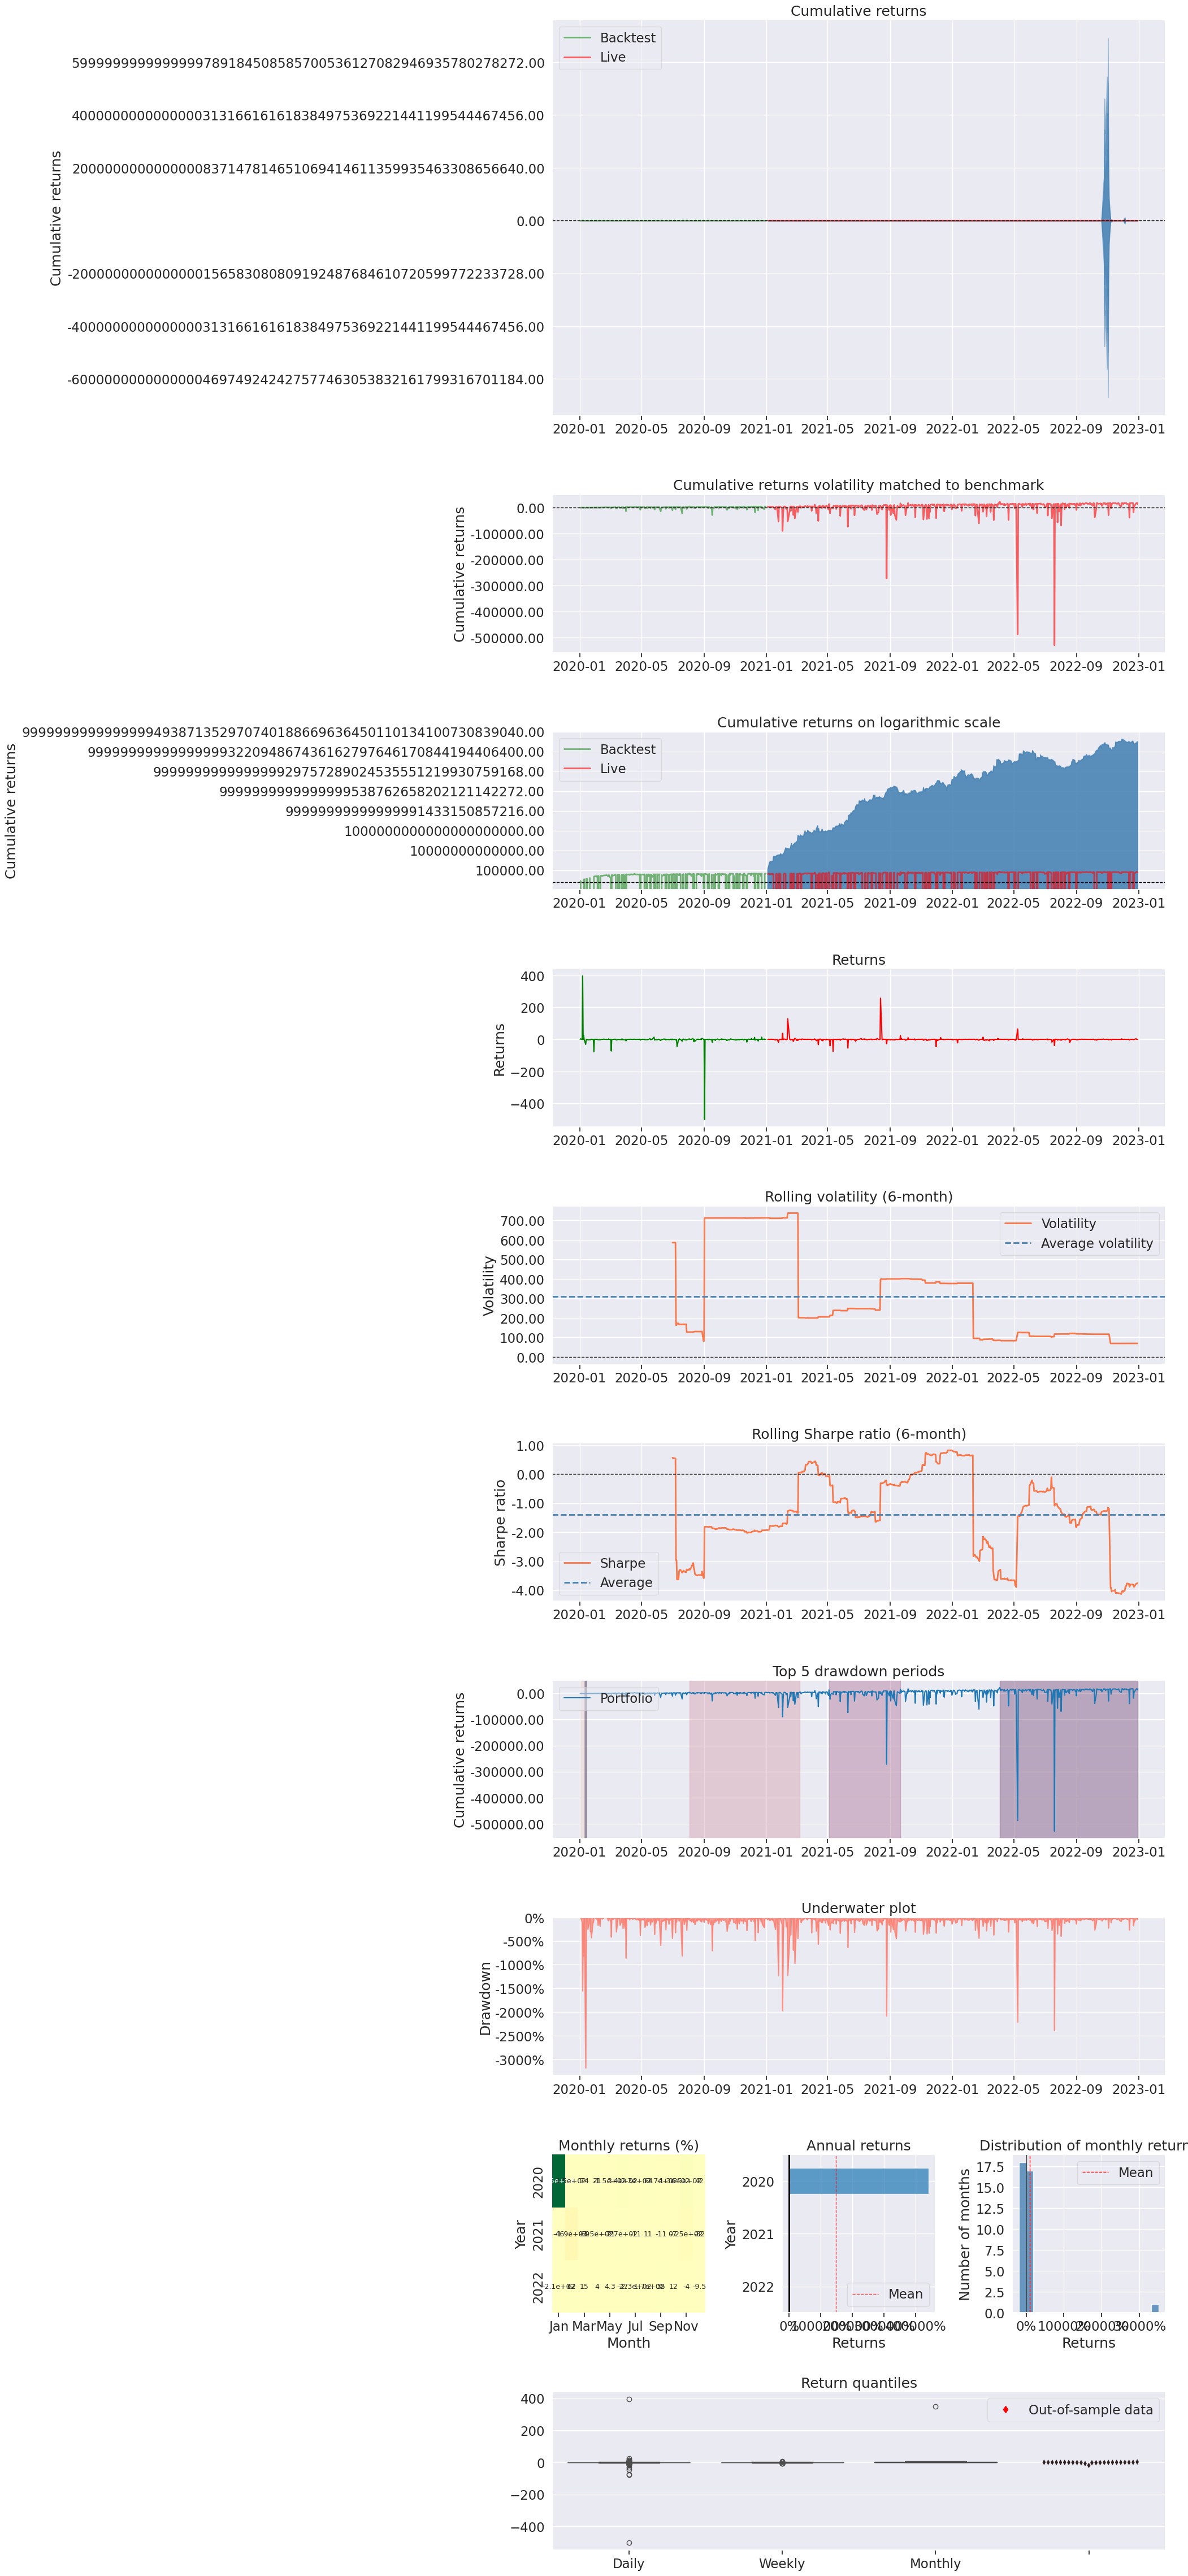

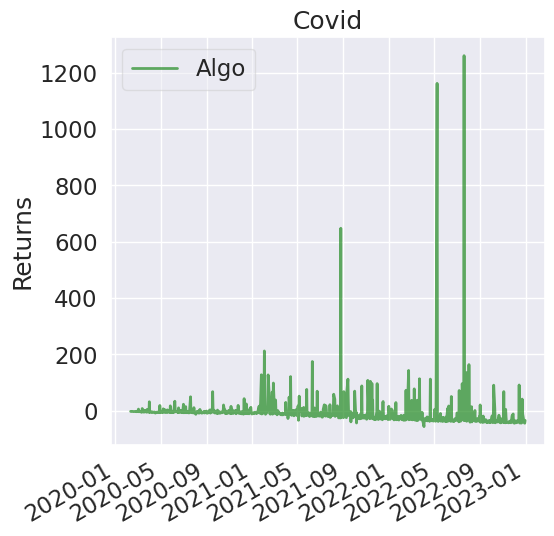

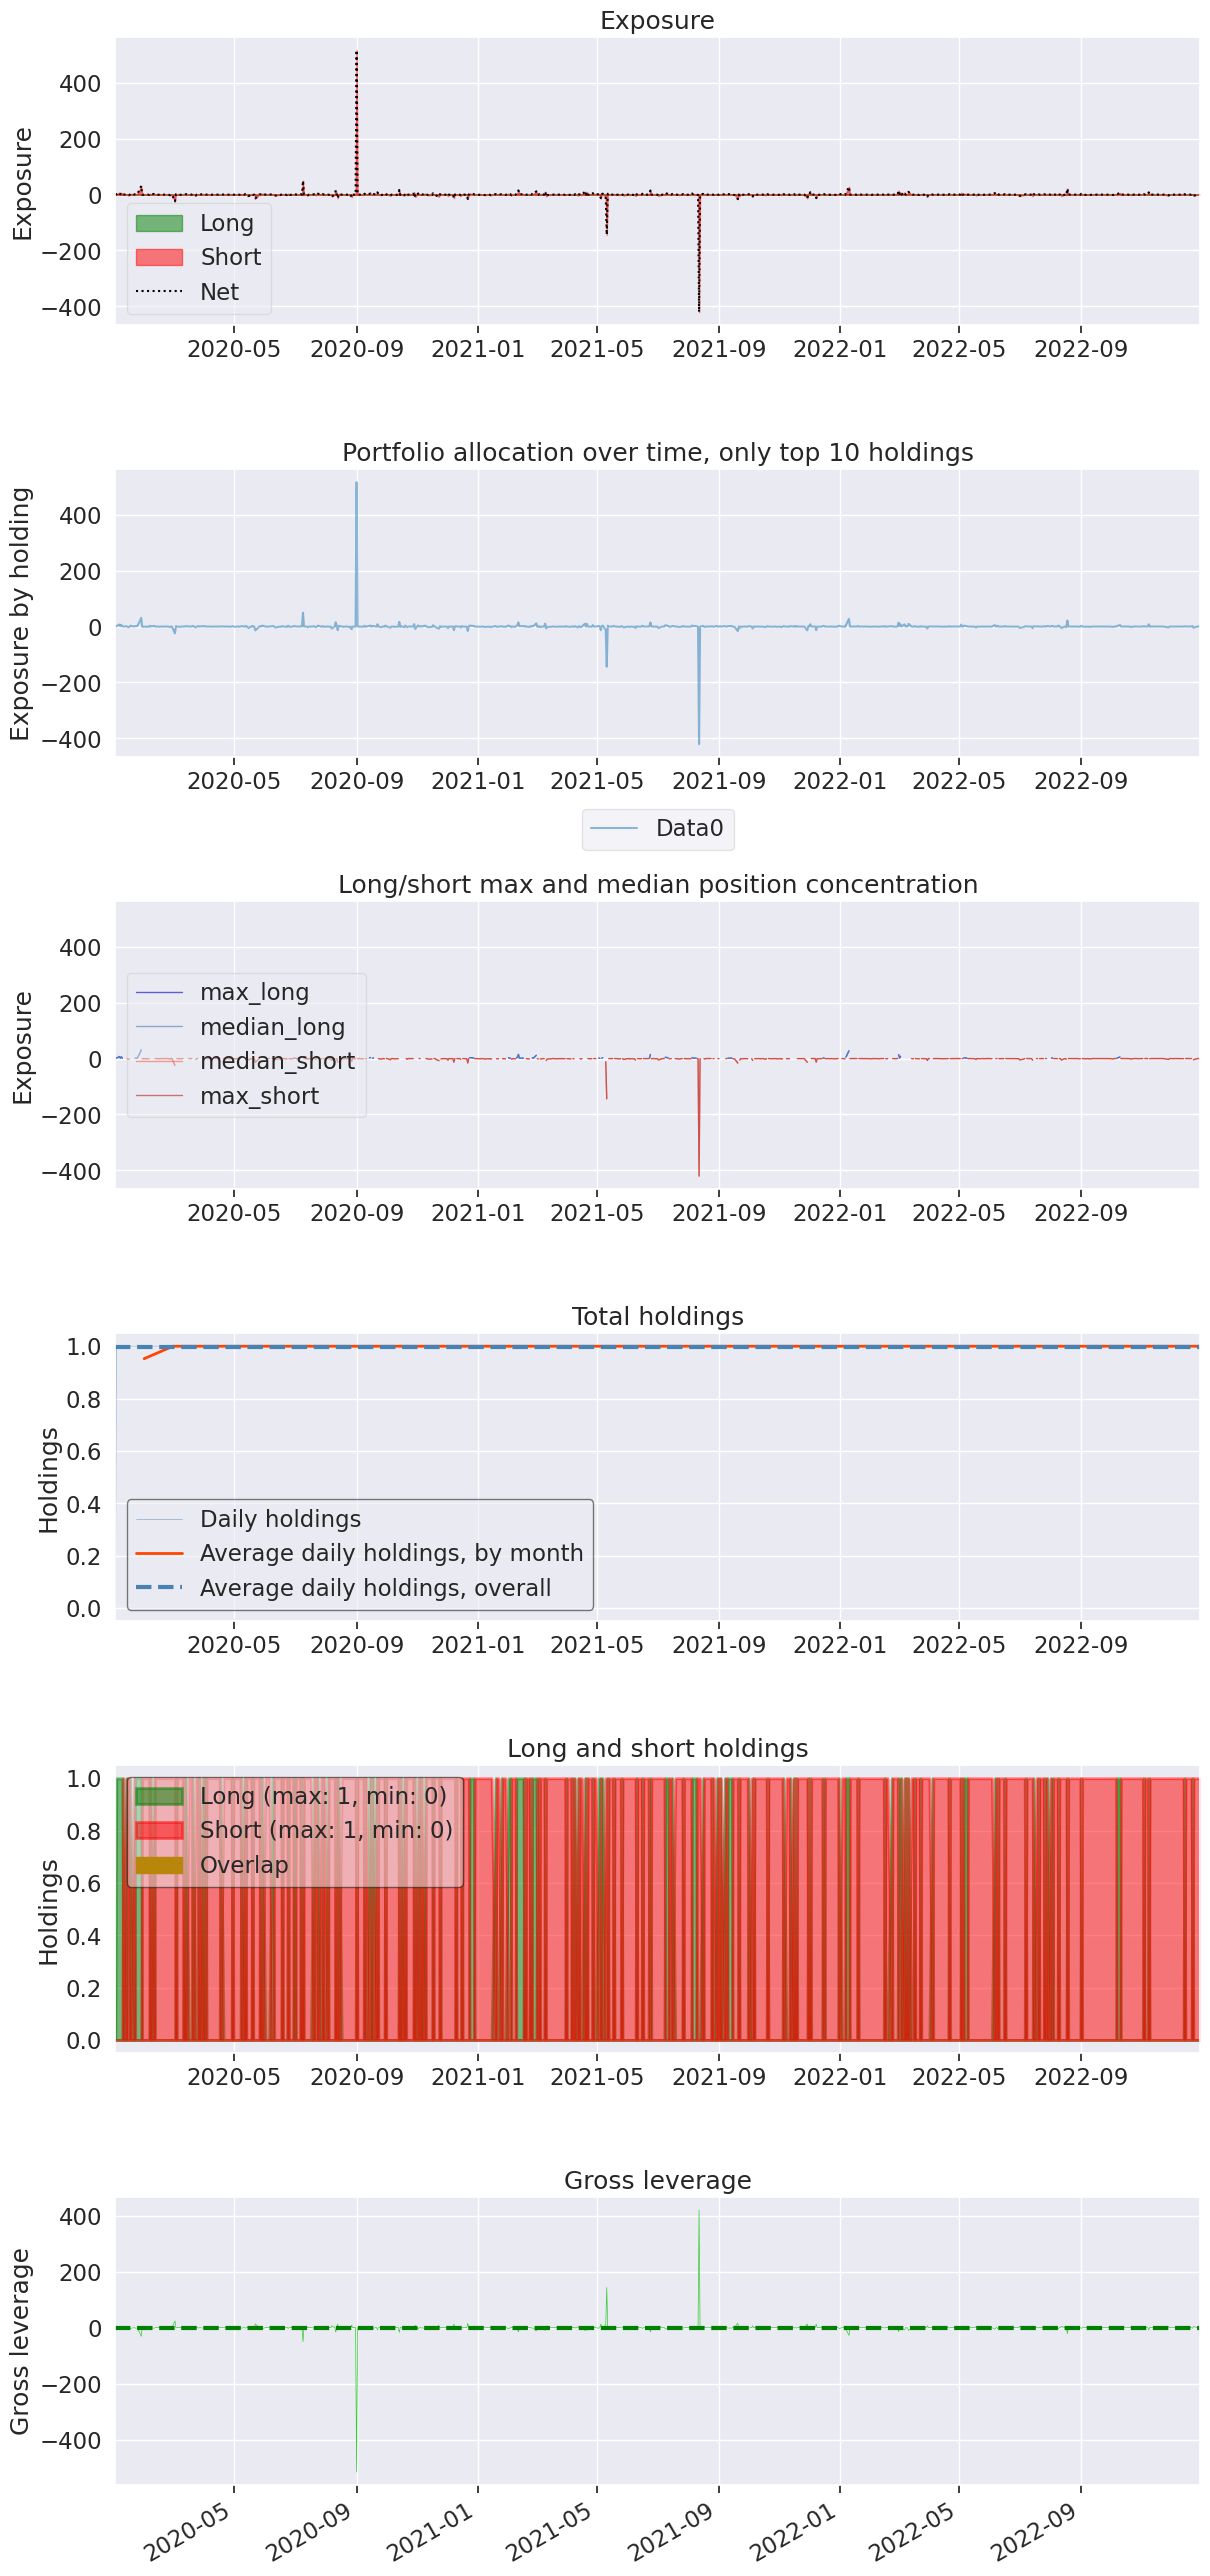

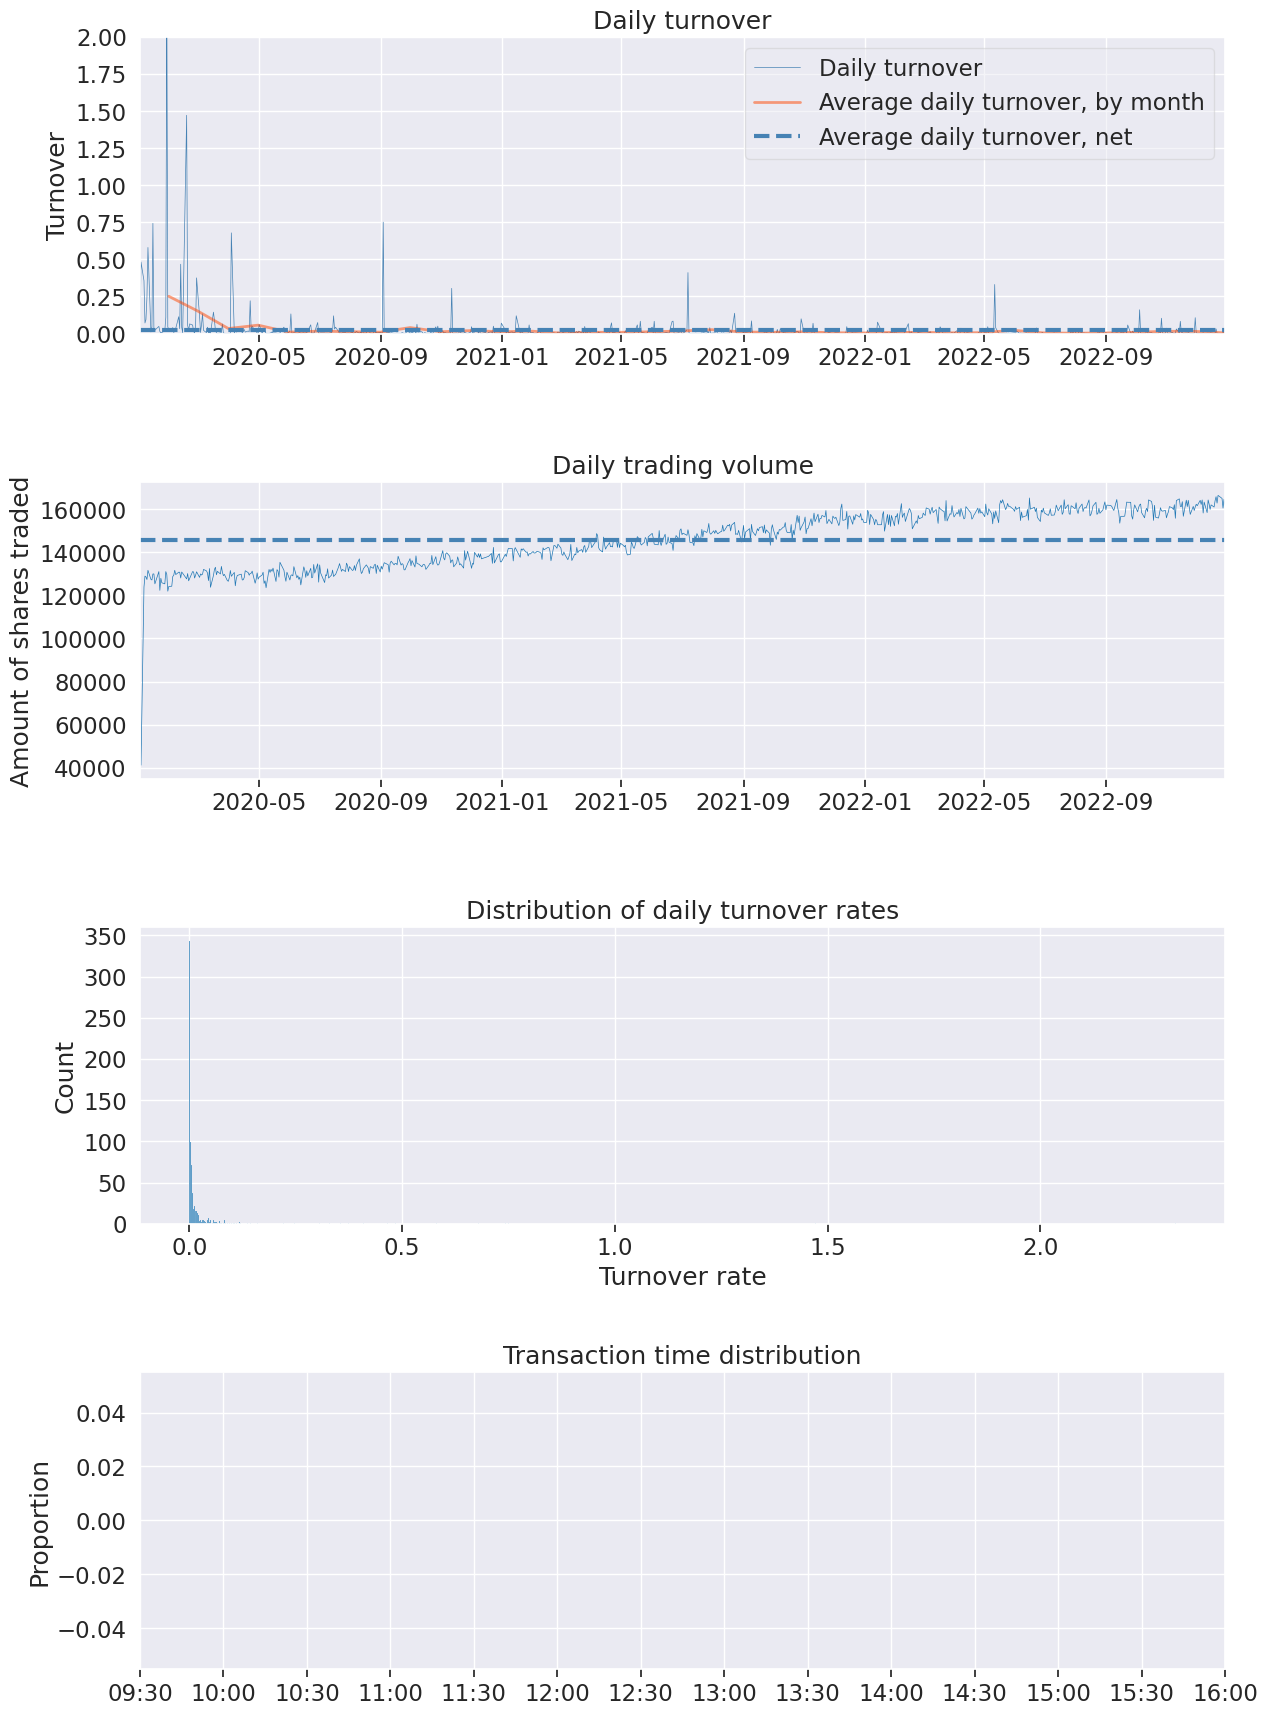

In [ ]:
import backtrader as bt
import pandas as pd
import pyfolio as pf

# Define a function to prepare data (with some added validation)
def prepare_data(start_date, end_date, tickers):
    """
    Prepares the historical data for backtesting.
    Args:
        start_date (str): The start date of the backtest.
        end_date (str): The end date of the backtest.
        tickers (list): List of ticker symbols for which to query data.

    Returns:
        pd.DataFrame: Processed data ready for backtesting.
    """
    # Query the data for the tickers
    cusips = get_cusips(tickers)  # Ensure get_cusips() returns the right identifiers
    equities_data = query_daily_data(start_date, end_date, cusips)

    # Convert data into a DataFrame and clean it up
    df = pd.DataFrame(equities_data)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    df.ffill(inplace=True)  # Forward fill any missing data points

    return df

# Define a custom data feed class to match the structure of your data
class CustomDataFeed(bt.feeds.PandasData):
    """
    Custom Backtrader data feed to map the correct columns.
    """
    params = (
        ('datetime', None),
        ('open', 'bid'),
        ('high', 'ask'),
        ('low', 'bid'),
        ('close', 'prc'),
        ('volume', 'vol'),
        ('openinterest', None),
    )

# Define a simple moving average crossover strategy
class SimpleStrategy(bt.Strategy):
    """
    A simple moving average crossover strategy.
    Buys when the price is above the moving average, sells when below.
    """
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=20)

    def next(self):
        if self.data.close[0] > self.sma[0] and not self.position:
            self.buy()  # Buy signal
        elif self.data.close[0] < self.sma[0] and self.position:
            self.sell()  # Sell signal

# Main function to run the backtest
def run_backtest():
    """
    Run the backtest and generate a performance tear sheet using PyFolio.
    """
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SimpleStrategy)

    # Prepare and add data feed
    start_date = '2020-01-01'
    end_date = '2022-12-31'
    tickers_bt = tickers#[:10]  # Limit the tickers for this example
    df = prepare_data(start_date, end_date, tickers_bt)

    # Add data feed to Backtrader
    data_feed = CustomDataFeed(dataname=df)
    cerebro.adddata(data_feed)

    # Set broker parameters
    cerebro.broker.set_cash(100000)
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Add PyFolio analyzer for performance tracking
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    # Run the backtest
    results = cerebro.run()

    # Extract the PyFolio analyzer
    pyfolio_analyzer = results[0].analyzers.pyfolio
    pf_items = pyfolio_analyzer.get_pf_items()

    # Unpack the results
    returns, positions, transactions = pf_items[:3]

    # Generate a PyFolio performance tear sheet
    pf.create_full_tear_sheet(
        returns,
        positions=positions,
        transactions=transactions,
        live_start_date='2021-01-01'
    )

    # Print the final portfolio value
    final_value = cerebro.broker.getvalue()
    print(f"Final Portfolio Value: ${final_value:,.2f}")

# Run the backtest
if __name__ == "__main__":
    run_backtest()
